# Test of the ACDM method for nospin hamiltonian using pyscf

The ACDM Lagrangian associated to the two-body Hamiltonian is

$$
    L \left[ D^{0}, \left\{ D^{i} \right\}_{i=1,n} \right]
        = \sum_{ii'}^n h_{ii'} <{A^{0}_{i}},{A^{0}_{i'}}> + \sum_{ii';jj'}^n H^{ii'}_{jj'} <{A^{i}_{j}},{A^{i'}_{j'}}>
        - {\underbrace{\mu_0 \left[ \sum_j^n <{A^{0}_{j}},{A^{0}_{j}}> - N \right]}_{\text{To have}\, N\,\text{electrons}}}
        - {\underbrace{\sum_{ii'}^n \lambda_{ii'} \left[ <{A^{0}_{i}},{A^{0}_{i'}}> + <{C^{0}_{i'}},{C^{0}_{i}}> 
                - \delta_{ii'}\right]}_{\text{To have}\, {A^{0\top}} A^{0} = \,\mathbb{I}_n}}\\
        - {\underbrace{\sum_{ii';jj'}^n \Lambda^{ii'}_{jj'} \left[  <{A^{i}_{j}},{A^{i'}_{j'}}> + <{C^{i}_{j'}},{C^{i'}_{j}}> 
                - \delta_{jj'}<{A^{0}_{i}},{A^{0}_{i'}}>\right]}_{\text{To have}\, {{A^{i}}^\top} A^{i'} + \left({C^{i\top}} C^{i'}\right)^\top = {}^1\Gamma_{ii'}\mathbb{I}_n}}
        - \sum_{ii'}^n {\underbrace{\mu_{ii'} \left[ \sum_j <{A^{i}_{j}},{A^{i'}_{j}}> 
                - (N-1)<{A^{0}_{i}},{A^{0}_{i'}}>\right]}_{\text{To have}\, {}^1\Gamma_{ii'}(N-1)\,\text{electrons} }}
$$

This is the original file. We use pySCF to compare with the solution using the Full Configuration Interaction Method. We use no class.


In [1]:
# Two-body hamiltonian and AIJ[i,j] = - AIJ[j,i] and regular matrices
import numpy as np
from pyscf import fci
from scipy.special import binom  #Binom formula
import scipy.optimize

#Indices for triangular 3D arrays AIJ and CIJ
def indices_3D(ind0,ind1,nA,pA,label):
    I0 = [] ; I1 = [] ; I2 = []
    for i in range(nA):
        for j in range(nA):
            I0.append(ind0[i]); I1.append(ind1[i]); I2.append(j)
    assert len(I2) == pA,'p=%d, pA=%d, nA=%d: %s' % (len(I2),pA,nA,label)
    return (I0,I1,I2)

#Size of X (to use scipy.optimize.root, we need a vector)
def Size_X():
    n0 = pA0+pC0+n2+1  #A0[n,n] C0[n,n] Lambda0[n,n] mu0
    n0 += pAIJ+pCIJ+n4 #AIJ[n,n,Am] CIJ[n,n,Cm] LambdaIJ[n,n,n,n] -- Convention of the paper i,i',j,j'
    n0 += n2 #muI[n,n]
    return n0

def Indice_mu0():
    return pA0+pC0+n2

def Indice_AIJ():
    return pA0+pC0+n2+1

def Indice_CIJ():
    return pA0+pC0+n2+1+pAIJ

def Indice_LambdaIJ():
    return pA0+pC0+n2+1+pAIJ+pCIJ

def Indice_muI():
    return pA0+pC0+n2+1+pAIJ+pCIJ+n4

#Pack A0, C0, Lambda0, mu0, AIJ, CIJ, LambdaIJ and muI into X
def Pack_X(A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI):
    X = np.zeros(Size_X())
    X[0:pA0] = np.reshape(A0,n*n)
    n0 = pA0+pC0
    X[pA0:n0] = np.reshape(C0,n*n)
    X[n0:n0+n2] = np.reshape(Lambda0,[n*n])
    n0 += n2
    X[n0] = mu0
    n0 = Indice_AIJ()
    X[n0:n0+pAIJ] = AIJ[indmAIJ]
    n0 = Indice_CIJ()
    X[n0:n0+pCIJ] = CIJ[indmCIJ]
    n0 = Indice_LambdaIJ()
    X[n0:n0+n4] = np.reshape(LambdaIJ,[n*n*n*n])
    n0 = Indice_muI()
    X[n0:n0+n2] = np.reshape(muI,[n*n]) 
    return X

#Depack X into A0, C0, Lambda0, mu0, AIJ, CIJ, LambdaIJ, and muI
def Depack_X(X):
    A0 = np.reshape(X[0:pA0],[n,n])
    n0 = pA0+pC0
    C0 = np.reshape(X[pA0:n0],[n,n])
    Lambda0 = np.reshape(X[n0:n0+n2],[n,n])
    n0 = Indice_mu0()
    mu0 = X[n0]
    n0 = Indice_AIJ()
    AIJ = np.zeros([n,n,nAIJ])
    AIJ[indmAIJ] = X[n0:n0+pAIJ]
    AIJ += - np.einsum('ijm->jim',AIJ)
    n0 = Indice_CIJ()
    CIJ = np.zeros([n,n,nCIJ])
    CIJ[indmCIJ] = X[n0:n0+pCIJ]
    n0 = Indice_LambdaIJ()
    LambdaIJ = np.reshape(X[n0:n0+n4],[n,n,n,n])
    n0 = Indice_muI()
    muI = np.reshape(X[n0:n0+n2],[n,n])
    return A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI

#Initial Guess based on h1
def Initial_X(h1,h2):
    #L,U = np.linalg.eigh(h1)
    L,U = np.linalg.eigh(h1)
    #First A0, C0, Lambda and mu
    mu0 = L[N]
    L_A0 = np.zeros(n)
    L_C0 = np.zeros(n)
    L_Lambda0 = np.zeros(n)
    for i in range(N):
        L_A0[i] = 1.0 #N occupation number to 1
        L_Lambda0[i] = L[i] - mu0
    for i in range(N,n):
        L_C0[i] = 1.0 #n-N hole to one
    A0 = np.einsum('ij,jm->im',U,np.diag(L_A0))
    C0 = np.einsum('ij,jm->im',U,np.diag(L_C0))
    Lambda0 = U@np.diag(L_Lambda0)@U.T
    #Then AIJ, CIJ, LambdaIJ, muI
    AIJ = np.zeros( [n,n,nAIJ] )
    l = 0
    for i in range(N):  #AIJ[i,i,:] = 0
        for j in range(i+1,N):
            AIJ[i,j,l] = np.float64(1.0)
            AIJ[j,i,l] = np.float64(-1.0)
            l += 1
    AIJ = np.einsum('ki,lj,ijm->klm',U,U,AIJ)
    CIJ = np.zeros( [n,n,nCIJ] )
    for i in range(N):
        #a+iai gives the same wavefunction 
        CIJ[i,i,0] = 1
        for j in range(N,n):
            CIJ[i,j,i*n+j] = np.float64(1.0)
    CIJ = np.einsum('ki,lj,ijm->klm',U,U,CIJ)
    LambdaIJ = np.zeros( [n,n,n,n] ) #Possibly to have a better guess with H2 and HF
    for i in range(n):
        for j in range(n):
            LambdaIJ[i,i,j,j] = h2[i,i,j,j]
            LambdaIJ[i,j,j,i] = h2[i,j,j,i]
    muI = np.zeros([n,n]) #Idem
    return Pack_X(A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI)

def Hamiltonian_Energy(X):
    A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI = Depack_X(X)
    return np.einsum('ij,im,jm->',h1,A0,A0) + 0.5*np.einsum('ijkl,ikm,jlm->',h2,AIJ,AIJ)

#Constraints for D0
def D0_Constraints(A0,C0):
    return np.einsum('im,jm->ij',A0,A0) + np.einsum('im,jm->ji',C0,C0) - np.eye(n)

#Constraints for A0
def A0_Constraints(A0):
    return (np.einsum('im,im->',A0,A0) - np.float64(N))

#Constraints for DIJ
def DIJ_Constraints(AIJ,CIJ,A0):
    return np.einsum('ijm,klm->ikjl',AIJ,AIJ) + np.einsum('ijm,klm->iklj',CIJ,CIJ) - np.einsum('im,jm,kl->ijkl',A0,A0, np.eye(n))

    
#Constraints for AIJ
def AIJ_Constraints(AIJ,A0):
    return np.einsum('ijm,kjm->ik',AIJ,AIJ) - np.einsum('im,km->ik',A0,A0)*np.float64(N-1)

#Lagrangian
def Lagrangian(X):
    A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI = Depack_X(X)
    return np.einsum('ij,im,jm->',h1,A0,A0) + 0.5*np.einsum('ijkl,ikm,jlm->',h2,AIJ,AIJ) \
        - mu0 * A0_Constraints(A0) - np.einsum('ij,ij->',Lambda0,D0_Constraints(A0,C0)) \
        - np.einsum('ij,ij->', muI, AIJ_Constraints(AIJ,A0)) - np.einsum('ijkl,ijkl->',LambdaIJ,DIJ_Constraints(AIJ,CIJ,A0))

#Gradient of Lagrangian
def Gradient_Lagrangian(X):
    A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI = Depack_X(X)
    HH = h1 - Lambda0 + np.float64(N-1)*muI + np.einsum('iIjj->iI',LambdaIJ) - mu0*np.eye(n)
    GA0 = np.einsum('ij,jm->im',HH,A0) + np.einsum('ij,im->jm',HH,A0)
    GC0 = - np.einsum('iI,im->Im',Lambda0,C0) - np.einsum('iI,Im->im',Lambda0,C0)
    GLambda0 = - D0_Constraints(A0,C0)
    Gmu0 = - A0_Constraints(A0)
    HH = np.float64(0.5)*h2 - LambdaIJ - np.einsum('iI,jJ->iIjJ',muI,np.eye(n))
    GAIJ = np.einsum('iIjJ,IJm->ijm',HH,AIJ) + np.einsum('iIjJ,ijm->IJm',HH,AIJ)
    GCIJ = - np.einsum('iIjJ,Ijm->iJm',LambdaIJ,CIJ) - np.einsum('iIjJ,iJm->Ijm',LambdaIJ,CIJ)
    GLambdaIJ = -DIJ_Constraints(AIJ,CIJ,A0)
    GmuI = - AIJ_Constraints(AIJ,A0)
    #AIJ[i,j] = - AIJ[j,i] so the gradient...
    GAIJ += - np.einsum('ijm->jim',GAIJ)
    return Pack_X(GA0,GC0,GLambda0,Gmu0,GAIJ,GCIJ,GLambdaIJ,GmuI)

#Testing the gradient
def test_Gradient_Lagrangian(X0,d):
    L0 = Lagrangian(X0)
    GX0 = Gradient_Lagrangian(X0)
    diff = np.zeros(len(X0))
    #To label the abscissae
    text = [ 'A0','C0','Lambda0','mu0','AIJ','CIJ','LambdaIJ','muI']
    pos = [ 0, pA0, pA0+pC0, Indice_mu0(), Indice_AIJ(), Indice_CIJ(),Indice_LambdaIJ(),Indice_muI() ]
    #
    p = 0
    for l in range(len(X0)):
        X1 = X0.copy()
        X1[l] += d
        L1 = Lagrangian(X1)
        diff[l] = (L1-L0)/d
        #print(l,X0[l],X1[l],L0,L1,GX0[l],diff[l])
        dd = abs(GX0[l]-diff[l])
        if p < len(pos)-1 and l>=pos[p+1]:
            p += 1
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    figure(figsize=(16, 6), dpi=80)
    x = np.array(range(len(X0)))
    y = GX0-diff
    for p,t in zip(pos,text):
        plt.text(p,0,t,rotation=90)
    plt.plot(x, GX0)
    plt.plot(x, diff,'--')
    plt.plot(x,y)
    plt.show() 

/local/deutsch/.local/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
np.random.seed(1) #For reproducibility

#To be changed as you like

n = 7
N = 4
assert N>1,'This script doe not work with one electron!'

norb = n
nelec = (N,0)
ndet = int(binom(norb,nelec[0]))
  
print('norb',norb,'nelec',nelec,'ndet',ndet)
h1 = np.float64(2.0*np.random.random((norb,norb)))
h2 = np.float64(-0.1*np.random.random((norb,norb,norb,norb)))

# Restore permutation symmetry
h1 = np.float64(0.5)*(h1 + h1.T)
h2 = np.float64(0.5)*(h2 + h2.transpose(1,0,2,3))
h2 = np.float64(0.5)*(h2 + h2.transpose(0,1,3,2))
h2 = np.float64(0.5)*(h2 + h2.transpose(2,3,0,1))

print('diff h1', max(abs(np.reshape(h1 - h1.T,n*n))))
print('diff h2.transpose(1,0,2,3)', max(abs(np.reshape(h2 - h2.transpose(1,0,2,3),n*n*n*n))))
print('diff h2.transpose(0,1,3,2)', max(abs(np.reshape(h2 - h2.transpose(0,1,3,2),n*n*n*n))))
print('diff h2.transpose(2,3,0,1)', max(abs(np.reshape(h2 - h2.transpose(2,3,0,1),n*n*n*n))))

n2 = n*n
n3 = n*n2
n4 = n2*n2
pA0 = n2        #Number of components for regular A0
pC0 = n2        #Number of components for regular C0

nAIJ = (n*(n-1))//2   #Number of AIJ[i,j]= - AIJ[j,i]
pAIJ = nAIJ*nAIJ      #Number of components of rectangular AIJ
indAIJ = np.triu_indices(n,k=1) #Indices of AIJ[i,j] with i<j
indmAIJ = indices_3D(indAIJ[0],indAIJ[1],nAIJ,pAIJ,'AIJ')
nCIJ = n*n         #Number of vectors for CIJ[i,j,:]
pCIJ = n*n*nCIJ   #Number of components of rectangular CIJ
indCIJ = np.reshape(np.mgrid[0:n,0:n],(2,n*n))
indmCIJ = indices_3D(indCIJ[0],indCIJ[1],nCIJ,pCIJ,'CIJ')

norb 7 nelec (4, 0) ndet 35
diff h1 0.0
diff h2.transpose(1,0,2,3) 0.0
diff h2.transpose(0,1,3,2) 0.0
diff h2.transpose(2,3,0,1) 0.0


In [3]:
# pspace function computes the FCI Hamiltonian for "primary" determinants.
# Primary determinants are the determinants which have lowest expectation
# value <H>.  np controls the number of primary determinants.
# To get the entire Hamiltonian, np should be larger than the wave-function
# size.  In this example, a (8e,7o) FCI problem has 1225 determinants.
H_fci = fci.direct_spin1.pspace(h1, h2, norb, nelec, np=ndet)[1]
e_all, v_all = np.linalg.eigh(H_fci)

e, fcivec = fci.direct_spin1.kernel(h1, h2, norb, nelec, nroots=2,
                                    max_space=30, max_cycle=100)

#print('First root:')
print('FCI energy', e[0])
print('wfn overlap', v_all[:,0].dot(fcivec[0].ravel()))

rdm1, rdm2 = fci.direct_spin1.make_rdm12(fcivec[0], norb, nelec)
#rdm1,rdm2 = fci.reorder_rdm(rdm1,rdm2)
FCI_energy = np.einsum('ij,ij->',h1,rdm1)+0.5*np.einsum('ijkl,ijkl->',h2,rdm2)
print('energy', e[0],FCI_energy)

FCI energy -1.486717548304986
wfn overlap 0.9696047851257639
energy -1.486717548304986 -1.4867175483049917


In [4]:
print('n',n,'N',N)
print('Number of components for A0:',pA0)
print('Number of components for C0:',pC0)
print('Number of vectors AIJ',nAIJ, ', number of components',pAIJ)
print('Number of vectors CIJ',nCIJ, ', number of components',pCIJ)
print('Total number of parameters for the Lagrangian (A0,C0,lambda0,mu0,AIJ,CIJ,LambdaIJ,muI):',Size_X())
print('Size of the Hessian:',Size_X()*Size_X())
print('-'*30,'Start of Initialization')

X0 = Initial_X(h1,h2)
A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI = Depack_X(X0)
print('mu0',mu0)
print('Hartree-Fock Energy target',Hamiltonian_Energy(X0), 'Lagrangian Hartree-Fock target', Lagrangian(X0))
print('Initial Lagrangian gradient Hartree-Fock',max(abs(Gradient_Lagrangian(X0))) )
print('Max D0_Constraints',max(abs(np.reshape(D0_Constraints(A0,C0),n*n))) )
print('Max A0_Constraints',A0_Constraints(A0))
print('Max DIJ_Constraints',max(abs(np.reshape(DIJ_Constraints(AIJ,CIJ,A0),n4))) )
print('Max AIJ_Constraints',max(abs(np.reshape(AIJ_Constraints(AIJ,A0),n2))) )
print('-'*30,'End of Initialization')

sol = scipy.optimize.root(fun=Gradient_Lagrangian, x0=X0,method='krylov', \
                              options={'disp': True, 'xatol': 1.e-7,'xtol': 1.e-4,'fatol': 1.e-6,'maxiter': 500, 'line_search': 'wolfe', \
                                       'jac_options': {'rdiff': 1.e-10, 'method': 'lgmres', 'inner_tol': 1.e-8}})


root = sol.x
A0,C0,Lambda,mu,AIJ,CIJ,LambdaIJ,muI = Depack_X(root)
ier = sol.status
mesg = sol.message
print('Number of electrons',np.trace(A0.T@A0))
print('Number of holes',np.trace(C0.T@C0))
print('Final energy',Hamiltonian_Energy(sol.x), 'Final Lagrangian', Lagrangian(sol.x), 'FCI energy',FCI_energy)
print('Message of fsolve ier=%d:' % ier,mesg)
print('Number of iterations',sol.nit)
print('Max Gradient values',max(sol.fun))

n 7 N 4
Number of components for A0: 49
Number of components for C0: 49
Number of vectors AIJ 21 , number of components 441
Number of vectors CIJ 49 , number of components 2401
Total number of parameters for the Lagrangian (A0,C0,lambda0,mu0,AIJ,CIJ,LambdaIJ,muI): 5440
Size of the Hessian: 29593600
------------------------------ Start of Initialization
mu0 1.1341918588975521
Hartree-Fock Energy target -1.477057101111585 Lagrangian Hartree-Fock target -1.4770571011115863
Initial Lagrangian gradient Hartree-Fock 0.5056055784954647
Max D0_Constraints 7.771561172376096e-16
Max A0_Constraints 0.0
Max DIJ_Constraints 5.551115123125783e-16
Max AIJ_Constraints 8.881784197001252e-16
------------------------------ End of Initialization
0:  |F(x)| = 0.0117916; step 1
1:  |F(x)| = 0.00840897; step 0.472149
2:  |F(x)| = 0.00610546; step 1
3:  |F(x)| = 0.00558355; step 1
4:  |F(x)| = 0.00571515; step 1
5:  |F(x)| = 0.00303317; step 1
6:  |F(x)| = 0.00254591; step 1
7:  |F(x)| = 0.00198254; step 1
8:

In [5]:
X0 = sol.x
A0,C0,Lambda0,mu0,AIJ,CIJ,LambdaIJ,muI = Depack_X(X0)

rdm1, rdm2 = fci.direct_spin1.make_rdm12(fcivec[0], norb, nelec)

print('n',n,'N',N)
print('Total number of parameters for the Lagrangian (A0,C0,lambda0,mu0,AIJ,CIJ,LambdaIJ,muI):',Size_X())

aa = np.einsum('im,km->ik',A0,A0)
cc = np.einsum('im,km->ik',C0,C0)
aaIJ = np.einsum('ijm,klm->ikjl',AIJ,AIJ)


(dm1a,dm1b),(dm2aa,dm2ab,dm2bb) = fci.direct_spin1.make_rdm12s(fcivec[0], norb, nelec)
assert(np.allclose(dm2aa+dm2ab+dm2ab.transpose(2,3,0,1)+dm2bb, rdm2))
print('no spin beta',max(abs(np.reshape(dm1b,n*n))))

N4_energy = Hamiltonian_Energy(X0)
FCI_energy = np.einsum('ij,ij->',h1,rdm1)+0.5*np.einsum('ijkl,ijkl->',h2,rdm2)
diff_energy = FCI_energy-N4_energy
print('FCI, N4 energies',FCI_energy,N4_energy,'diff',diff_energy,\
      'percentage %7.5f%%' % (100.0*(1.0-abs(diff_energy/FCI_energy))) )

FCI_e1 = np.einsum('ij,ij->',h1,dm1a)
N4_e1 = np.einsum('ij,ij->',h1,aa)
diff_e1 = FCI_e1 - N4_e1
print('FCI,N4 h1 energy', FCI_e1,N4_e1,'diff',FCI_e1-N4_e1,'percentage %7.5f%%' % (100.0*(1.0-abs(diff_e1/FCI_e1))) )

FCI_e2 = 0.5*np.einsum('ijkl,ijkl->',h2,rdm2)
N4_e2 = 0.5*np.einsum('ijkl,ijkl->',h2,aaIJ)
diff_e2 = FCI_e2 - N4_e2
print('FCI,N4 h2 energy', FCI_e2,N4_e2,'diff',FCI_e2-N4_e2,'percentage %7.5f%%' % (100.0*(1.0-abs(diff_e2/FCI_e2))) )

print('diff RDM1',max(abs(np.reshape(aa-rdm1,n*n))))
print('diff RDM2',max(abs(np.reshape(aaIJ-rdm2,n*n*n*n))))

n 7 N 4
Total number of parameters for the Lagrangian (A0,C0,lambda0,mu0,AIJ,CIJ,LambdaIJ,muI): 5440
no spin beta 0.0
FCI, N4 energies -1.4867175483049917 -1.4864315873710103 diff -0.00028596093398136624 percentage 99.98077%
FCI,N4 h1 energy -1.4270446218571506 -1.4275417553929548 diff 0.0004971335358041618 percentage 99.96516%
FCI,N4 h2 energy -0.059672926447841085 -0.05888983197805312 diff -0.0007830944697879635 percentage 98.68769%
diff RDM1 0.000402667150997682
diff RDM2 0.0020805184789764453


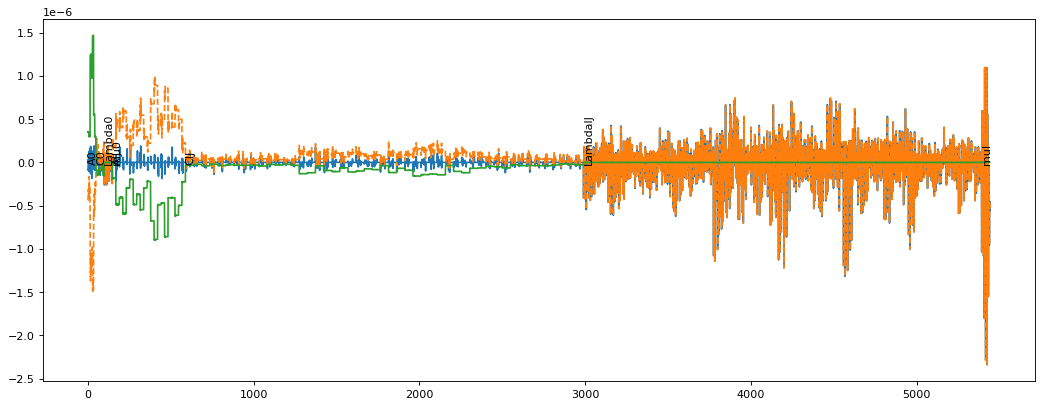

In [6]:
d = 0.0000001
test_Gradient_Lagrangian(X0+0.1*np.random.rand(Si,d)